MultiRocket adds 3 pooling operators:
 Mean of Positive Values (MPV); Mean of Indices of Positive Values (MIPV); and Longest Stretch of Positive Values (LSPV).

##Multirocket code

In [ ]:
# %%capture
# import multiprocessing
# from itertools import combinations

# import numpy as np
# from numba import get_num_threads, njit, prange, set_num_threads
# !pip install aeon[all_extras] --quiet
# from aeon.transformations.collection import BaseCollectionTransformer


# class MultiRocket(BaseCollectionTransformer):
#     """Multi RandOm Convolutional KErnel Transform (MultiRocket).

#     MultiRocket [1]_ uses the same set of kernels as MiniRocket on both the raw
#     series and the first order differenced series representation. It uses a different
#     set of dilations and used for each representation. In addition to percentage of
#     positive values (PPV), MultiRocket adds 3 pooling operators: Mean of Positive
#     Values (MPV); Mean of Indices of Positive Values (MIPV); and Longest Stretch of
#     Positive Values (LSPV).

#     Parameters
#     ----------
#     num_kernels : int, default = 6,250
#        Number of random convolutional kernels. The calculated number of features is the
#        nearest multiple of ``n_features_per_kernel(default 4)*84=336 < 50,000``
#        (``2*n_features_per_kernel(default 4)*num_kernels(default 6,250)``).
#     max_dilations_per_kernel : int, default = 32
#         Maximum number of dilations per kernel.
#     n_features_per_kernel : int, default = 4
#         Number of features per kernel.
#     normalise : bool, default False
#         Whether or not to normalise the input time series per instance.
#     n_jobs : int, default=1
#         The number of jobs to run in parallel for `transform`. ``-1`` means using all
#         processors.
#     random_state : None or int, default = None
#         Seed for random number generation.

#     Attributes
#     ----------
#     parameter : tuple
#         Parameter (dilations, n_features_per_dilation, biases) for
#         transformation of input `X`.
#     parameter1 : tuple
#         Parameter (dilations, n_features_per_dilation, biases) for
#         transformation of input ``X1 = np.diff(X, 1)``.


#     See Also
#     --------
#     MiniRocket, Rocket

#     References
#     ----------
#     .. [1] Tan, Chang Wei and Dempster, Angus and Bergmeir, Christoph and
#     Webb, Geoffrey I, "MultiRocket: Multiple pooling operators and transformations
#     for fast and effective time series classification",2022,
#     https://link.springer.com/article/10.1007/s10618-022-00844-1
#     https://arxiv.org/abs/2102.00457

#     Examples
#     --------
#      >>> from aeon.transformations.collection.convolution_based import MultiRocket
#      >>> from aeon.datasets import load_unit_test
#      >>> X_train, y_train = load_unit_test(split="train")
#      >>> X_test, y_test = load_unit_test(split="test")
#      >>> trf = MultiRocket(num_kernels=512)
#      >>> trf.fit(X_train)
#      MultiRocket(num_kernels=512)
#      >>> X_train = trf.transform(X_train)
#      >>> X_test = trf.transform(X_test)
#     """

#     _tags = {
#         "output_data_type": "Tabular",
#         "algorithm_type": "convolution",
#         "capability:multivariate": True,
#     }
#     # indices for the 84 kernels used by MiniRocket
#     _indices = np.array([_ for _ in combinations(np.arange(9), 3)], dtype=np.int32)

#     def __init__(
#         self,
#         num_kernels=6_250,
#         max_dilations_per_kernel=32,
#         n_features_per_kernel=4,
#         normalise=False,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.max_dilations_per_kernel = max_dilations_per_kernel
#         self.n_features_per_kernel = n_features_per_kernel

#         self.num_kernels = num_kernels

#         self.normalise = normalise
#         self.n_jobs = n_jobs
#         self.random_state = random_state
#         self.parameter = None
#         self.parameter1 = None

#         super().__init__()

#     def _fit(self, X, y=None):
#         """Fit dilations and biases to input time series.

#         Parameters
#         ----------
#         X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
#             Collection of time series to transform
#         y : ignored argument for interface compatibility

#         Returns
#         -------
#         self
#         """
#         self.random_state_ = (
#             np.int32(self.random_state) if isinstance(self.random_state, int) else None
#         )
#         if self.random_state_ is not None:
#             np.random.seed(self.random_state_)

#         _, n_channels, n_timepoints = X.shape
#         if n_timepoints < 9:
#             raise ValueError(
#                 f"n_timepoints must be >= 9, but found {n_timepoints};"
#                 " zero pad shorter series so that n_timepoints == 9"
#             )
#         X = X.astype(np.float32)
#         if self.normalise:
#             X = (X - X.mean(axis=-1, keepdims=True)) / (
#                 X.std(axis=-1, keepdims=True) + 1e-8
#             )
#         if n_channels == 1:
#             X = X.squeeze()
#             self.parameter = self._fit_univariate(X)
#             _X1 = np.diff(X, 1)
#             self.parameter1 = self._fit_univariate(_X1)
#         else:
#             self.parameter = self._fit_multivariate(X)
#             _X1 = np.diff(X, 1)
#             self.parameter1 = self._fit_multivariate(_X1)

#         return self

#     def _transform(self, X, y=None):
#         """Transform input time series using random convolutional kernels.

#         Parameters
#         ----------
#         X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
#             Collection of time series to transform.
#         y : ignored argument for interface compatibility

#         Returns
#         -------
#         pandas DataFrame, transformed features
#         """
#         _, n_channels, n_timepoints = X.shape
#         if self.normalise:
#             X = (X - X.mean(axis=-1, keepdims=True)) / (
#                 X.std(axis=-1, keepdims=True) + 1e-8
#             )
#         # change n_jobs dependend on value and existing cores
#         prev_threads = get_num_threads()
#         if self.n_jobs < 1 or self.n_jobs > multiprocessing.cpu_count():
#             n_jobs = multiprocessing.cpu_count()
#         else:
#             n_jobs = self.n_jobs
#         set_num_threads(n_jobs)

#         X = X.astype(np.float32)
#         if n_channels > 1:
#             X1 = np.diff(X, 1)
#             X = _transform_multi(
#                 X,
#                 X1,
#                 self.parameter,
#                 self.parameter1,
#                 self.n_features_per_kernel,
#                 MultiRocket._indices,
#                 self.random_state_,
#             )
#         else:
#             X = X.reshape(X.shape[0], X.shape[2])
#             X1 = np.diff(X, 1)
#             X = _transform_uni(
#                 X,
#                 X1,
#                 self.parameter,
#                 self.parameter1,
#                 self.n_features_per_kernel,
#                 MultiRocket._indices,
#                 self.random_state_,
#             )

#         X = np.nan_to_num(X)  # not sure about this!

#         set_num_threads(prev_threads)
#         return X

#     def _fit_univariate(self, X):
#         _, input_length = X.shape

#         num_kernels = 84

#         dilations, num_features_per_dilation = _fit_dilations(
#             input_length, self.num_kernels, self.max_dilations_per_kernel
#         )

#         num_features_per_kernel = np.sum(num_features_per_dilation)

#         quantiles = _quantiles(num_kernels * num_features_per_kernel)

#         biases = _fit_biases_univariate(
#             X,
#             dilations,
#             num_features_per_dilation,
#             quantiles,
#             MultiRocket._indices,
#             self.random_state_,
#         )

#         return dilations, num_features_per_dilation, biases

#     def _fit_multivariate(self, X):
#         _, num_channels, input_length = X.shape

#         num_kernels = 84

#         dilations, num_features_per_dilation = _fit_dilations(
#             input_length, self.num_kernels, self.max_dilations_per_kernel
#         )

#         num_features_per_kernel = np.sum(num_features_per_dilation)

#         quantiles = _quantiles(num_kernels * num_features_per_kernel)

#         num_dilations = len(dilations)
#         num_combinations = num_kernels * num_dilations

#         max_num_channels = min(num_channels, 9)
#         max_exponent = np.log2(max_num_channels + 1)

#         num_channels_per_combination = (
#             2 ** np.random.uniform(0, max_exponent, num_combinations)
#         ).astype(np.int32)

#         channel_indices = np.zeros(num_channels_per_combination.sum(), dtype=np.int32)

#         num_channels_start = 0
#         for combination_index in range(num_combinations):
#             num_channels_this_combination = num_channels_per_combination[
#                 combination_index
#             ]
#             num_channels_end = num_channels_start + num_channels_this_combination
#             channel_indices[num_channels_start:num_channels_end] = np.random.choice(
#                 num_channels, num_channels_this_combination, replace=False
#             )

#             num_channels_start = num_channels_end

#         biases = _fit_biases_multivariate(
#             X,
#             num_channels_per_combination,
#             channel_indices,
#             dilations,
#             num_features_per_dilation,
#             quantiles,
#             MultiRocket._indices,
#             self.random_state_,
#         )

#         return (
#             num_channels_per_combination,
#             channel_indices,
#             dilations,
#             num_features_per_dilation,
#             biases,
#         )


# @njit(
#     "float32[:,:](float32[:,:],float32[:,:],Tuple((int32[:],int32[:],float32[:])),"
#     "Tuple((int32[:],int32[:],float32[:])),int32, int32[:,:],optional(int32))",
#     fastmath=True,
#     parallel=True,
#     cache=True,
# )
# def _transform_uni(
#     X, X1, parameters, parameters1, n_features_per_kernel, indices, seed
# ):
#     if seed is not None:
#         np.random.seed(seed)
#     n_cases, n_timepoints = X.shape

#     dilations, num_features_per_dilation, biases = parameters
#     dilations1, num_features_per_dilation1, biases1 = parameters1
#     num_kernels = len(indices)
#     num_dilations = len(dilations)
#     num_dilations1 = len(dilations1)

#     num_features = num_kernels * np.sum(num_features_per_dilation)
#     num_features1 = num_kernels * np.sum(num_features_per_dilation1)

#     features = np.zeros(
#         (n_cases, (num_features + num_features1) * n_features_per_kernel),
#         dtype=np.float32,
#     )
#     n_features_per_transform = np.int64(features.shape[1] / 2)

#     for example_index in prange(n_cases):
#         _X = X[example_index]

#         A = -_X  # A = alpha * X = -X
#         G = _X + _X + _X  # G = gamma * X = 3X

#         # Base series
#         feature_index_start = 0

#         for dilation_index in range(num_dilations):
#             _padding0 = dilation_index % 2

#             dilation = dilations[dilation_index]
#             padding = ((9 - 1) * dilation) // 2

#             num_features_this_dilation = num_features_per_dilation[dilation_index]

#             C_alpha = np.zeros(n_timepoints, dtype=np.float32)
#             C_alpha[:] = A

#             C_gamma = np.zeros((9, n_timepoints), dtype=np.float32)
#             C_gamma[9 // 2] = G

#             start = dilation
#             end = n_timepoints - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[-end:] = C_alpha[-end:] + A[:end]
#                 C_gamma[gamma_index, -end:] = G[:end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:-start] = C_alpha[:-start] + A[start:]
#                 C_gamma[gamma_index, :-start] = G[start:]

#                 start += dilation

#             for kernel_index in range(num_kernels):
#                 feature_index_end = feature_index_start + num_features_this_dilation

#                 _padding1 = (_padding0 + kernel_index) % 2

#                 index_0, index_1, index_2 = indices[kernel_index]

#                 C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]

#                 if _padding1 == 0:
#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(C.shape[0]):
#                             if C[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += C[j] + _bias
#                             elif C[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = C.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index
#                         features[example_index, end] = ppv / C.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )
#                 else:
#                     _c = C[padding:-padding]

#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(_c.shape[0]):
#                             if _c[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += _c[j] + _bias
#                             elif _c[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = _c.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index
#                         features[example_index, end] = ppv / _c.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )

#                 feature_index_start = feature_index_end

#         # First order difference
#         _X1 = X1[example_index]
#         A1 = -_X1  # A = alpha * X = -X
#         G1 = _X1 + _X1 + _X1  # G = gamma * X = 3X

#         feature_index_start = 0

#         for dilation_index in range(num_dilations1):
#             _padding0 = dilation_index % 2

#             dilation = dilations1[dilation_index]
#             padding = ((9 - 1) * dilation) // 2

#             num_features_this_dilation = num_features_per_dilation1[dilation_index]

#             C_alpha = np.zeros(n_timepoints - 1, dtype=np.float32)
#             C_alpha[:] = A1

#             C_gamma = np.zeros((9, n_timepoints - 1), dtype=np.float32)
#             C_gamma[9 // 2] = G1

#             start = dilation
#             end = n_timepoints - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[-end:] = C_alpha[-end:] + A1[:end]
#                 C_gamma[gamma_index, -end:] = G1[:end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:-start] = C_alpha[:-start] + A1[start:]
#                 C_gamma[gamma_index, :-start] = G1[start:]

#                 start += dilation

#             for kernel_index in range(num_kernels):
#                 feature_index_end = feature_index_start + num_features_this_dilation

#                 _padding1 = (_padding0 + kernel_index) % 2

#                 index_0, index_1, index_2 = indices[kernel_index]

#                 C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]

#                 if _padding1 == 0:
#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases1[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(C.shape[0]):
#                             if C[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += C[j] + _bias
#                             elif C[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = C.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index + n_features_per_transform
#                         features[example_index, end] = ppv / C.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )
#                 else:
#                     _c = C[padding:-padding]

#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases1[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(_c.shape[0]):
#                             if _c[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += _c[j] + _bias
#                             elif _c[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = _c.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index + n_features_per_transform
#                         features[example_index, end] = ppv / _c.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )

#                 feature_index_start = feature_index_end

#     return features


# @njit(
#     "float32[:,:](float32[:,:,:],float32[:,:,:],"
#     "Tuple((int32[:],int32[:],int32[:],int32[:],float32[:])),"
#     "Tuple((int32[:],int32[:],int32[:],int32[:],float32[:])),int32, int32[:,:],"
#     "optional(int32))",
#     fastmath=True,
#     parallel=True,
#     cache=True,
# )
# def _transform_multi(
#     X, X1, parameters, parameters1, n_features_per_kernel, indices, seed
# ):
#     n_cases, n_channels, n_timepoints = X.shape
#     (
#         num_channels_per_combination,
#         channel_indices,
#         dilations,
#         num_features_per_dilation,
#         biases,
#     ) = parameters
#     if seed is not None:
#         np.random.seed(seed)

#     _, _, dilations1, num_features_per_dilation1, biases1 = parameters1
#     num_kernels = len(indices)
#     num_dilations = len(dilations)
#     num_dilations1 = len(dilations1)

#     num_features = num_kernels * np.sum(num_features_per_dilation)
#     num_features1 = num_kernels * np.sum(num_features_per_dilation1)

#     features = np.zeros(
#         (n_cases, (num_features + num_features1) * n_features_per_kernel),
#         dtype=np.float32,
#     )
#     n_features_per_transform = np.int64(features.shape[1] / 2)
#     for example_index in prange(n_cases):
#         _X = X[example_index]

#         A = -_X  # A = alpha * X = -X
#         G = _X + _X + _X  # G = gamma * X = 3X

#         # Base series
#         feature_index_start = 0

#         combination_index = 0
#         num_channels_start = 0

#         for dilation_index in range(num_dilations):
#             _padding0 = dilation_index % 2

#             dilation = dilations[dilation_index]
#             padding = ((9 - 1) * dilation) // 2

#             num_features_this_dilation = num_features_per_dilation[dilation_index]

#             C_alpha = np.zeros((n_channels, n_timepoints), dtype=np.float32)
#             C_alpha[:] = A

#             C_gamma = np.zeros((9, n_channels, n_timepoints), dtype=np.float32)
#             C_gamma[9 // 2] = G

#             start = dilation
#             end = n_timepoints - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[:, -end:] = C_alpha[:, -end:] + A[:, :end]
#                 C_gamma[gamma_index, :, -end:] = G[:, :end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:, :-start] = C_alpha[:, :-start] + A[:, start:]
#                 C_gamma[gamma_index, :, :-start] = G[:, start:]

#                 start += dilation

#             for kernel_index in range(num_kernels):
#                 feature_index_end = feature_index_start + num_features_this_dilation

#                 num_channels_this_combination = num_channels_per_combination[
#                     combination_index
#                 ]

#                 num_channels_end = num_channels_start + num_channels_this_combination

#                 channels_this_combination = channel_indices[
#                     num_channels_start:num_channels_end
#                 ]

#                 _padding1 = (_padding0 + kernel_index) % 2

#                 index_0, index_1, index_2 = indices[kernel_index]

#                 C = (
#                     C_alpha[channels_this_combination]
#                     + C_gamma[index_0][channels_this_combination]
#                     + C_gamma[index_1][channels_this_combination]
#                     + C_gamma[index_2][channels_this_combination]
#                 )
#                 C = np.sum(C, axis=0)

#                 if _padding1 == 0:
#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(C.shape[0]):
#                             if C[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += C[j] + _bias
#                             elif C[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = C.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index
#                         features[example_index, end] = ppv / C.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )
#                 else:
#                     _c = C[padding:-padding]

#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(_c.shape[0]):
#                             if _c[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += _c[j] + _bias
#                             elif _c[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = _c.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index
#                         features[example_index, end] = ppv / _c.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )

#                 feature_index_start = feature_index_end

#                 combination_index += 1
#                 num_channels_start = num_channels_end

#         # First order difference
#         _X1 = X1[example_index]
#         A1 = -_X1  # A = alpha * X = -X
#         G1 = _X1 + _X1 + _X1  # G = gamma * X = 3X

#         feature_index_start = 0

#         combination_index = 0
#         num_channels_start = 0

#         for dilation_index in range(num_dilations1):
#             _padding0 = dilation_index % 2

#             dilation = dilations1[dilation_index]
#             padding = ((9 - 1) * dilation) // 2

#             num_features_this_dilation = num_features_per_dilation1[dilation_index]

#             C_alpha = np.zeros((n_channels, n_timepoints - 1), dtype=np.float32)
#             C_alpha[:] = A1

#             C_gamma = np.zeros((9, n_channels, n_timepoints - 1), dtype=np.float32)
#             C_gamma[9 // 2] = G1

#             start = dilation
#             end = n_timepoints - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[:, -end:] = C_alpha[:, -end:] + A1[:, :end]
#                 C_gamma[gamma_index, :, -end:] = G1[:, :end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:, :-start] = C_alpha[:, :-start] + A1[:, start:]
#                 C_gamma[gamma_index, :, :-start] = G1[:, start:]

#                 start += dilation

#             for kernel_index in range(num_kernels):
#                 feature_index_end = feature_index_start + num_features_this_dilation

#                 num_channels_this_combination = num_channels_per_combination[
#                     combination_index
#                 ]

#                 num_channels_end = num_channels_start + num_channels_this_combination

#                 channels_this_combination = channel_indices[
#                     num_channels_start:num_channels_end
#                 ]

#                 _padding1 = (_padding0 + kernel_index) % 2

#                 index_0, index_1, index_2 = indices[kernel_index]

#                 C = (
#                     C_alpha[channels_this_combination]
#                     + C_gamma[index_0][channels_this_combination]
#                     + C_gamma[index_1][channels_this_combination]
#                     + C_gamma[index_2][channels_this_combination]
#                 )
#                 C = np.sum(C, axis=0)

#                 if _padding1 == 0:
#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases1[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(C.shape[0]):
#                             if C[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += C[j] + _bias
#                             elif C[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = C.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index + n_features_per_transform
#                         features[example_index, end] = ppv / C.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )
#                 else:
#                     _c = C[padding:-padding]

#                     for feature_count in range(num_features_this_dilation):
#                         feature_index = feature_index_start + feature_count
#                         _bias = biases1[feature_index]

#                         ppv = 0
#                         last_val = 0
#                         max_stretch = 0.0
#                         mean_index = 0
#                         mean = 0

#                         for j in range(_c.shape[0]):
#                             if _c[j] > _bias:
#                                 ppv += 1
#                                 mean_index += j
#                                 mean += _c[j] + _bias
#                             elif _c[j] < _bias:
#                                 stretch = j - last_val
#                                 if stretch > max_stretch:
#                                     max_stretch = stretch
#                                 last_val = j
#                         stretch = _c.shape[0] - 1 - last_val
#                         if stretch > max_stretch:
#                             max_stretch = stretch

#                         end = feature_index + n_features_per_transform
#                         features[example_index, end] = ppv / _c.shape[0]
#                         end = end + num_features
#                         features[example_index, end] = max_stretch
#                         end = end + num_features
#                         features[example_index, end] = mean / ppv if ppv > 0 else 0
#                         end = end + num_features
#                         features[example_index, end] = (
#                             mean_index / ppv if ppv > 0 else -1
#                         )

#                 feature_index_start = feature_index_end

#     return features


# @njit(
#     "float32[:](float32[:,:],int32[:],int32[:],float32[:], int32[:,:],optional(int32))",
#     fastmath=True,
#     parallel=False,
#     cache=True,
# )
# def _fit_biases_univariate(
#     X, dilations, num_features_per_dilation, quantiles, indices, seed
# ):
#     if seed is not None:
#         np.random.seed(seed)

#     num_examples, input_length = X.shape
#     num_kernels = len(indices)
#     num_dilations = len(dilations)

#     num_features = num_kernels * np.sum(num_features_per_dilation)

#     biases = np.zeros(num_features, dtype=np.float32)

#     feature_index_start = 0

#     for dilation_index in range(num_dilations):
#         dilation = dilations[dilation_index]
#         padding = ((9 - 1) * dilation) // 2

#         num_features_this_dilation = num_features_per_dilation[dilation_index]

#         for kernel_index in range(num_kernels):
#             feature_index_end = feature_index_start + num_features_this_dilation

#             _X = X[np.random.randint(num_examples)]

#             A = -_X  # A = alpha * X = -X
#             G = _X + _X + _X  # G = gamma * X = 3X

#             C_alpha = np.zeros(input_length, dtype=np.float32)
#             C_alpha[:] = A

#             C_gamma = np.zeros((9, input_length), dtype=np.float32)
#             C_gamma[9 // 2] = G

#             start = dilation
#             end = input_length - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[-end:] = C_alpha[-end:] + A[:end]
#                 C_gamma[gamma_index, -end:] = G[:end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:-start] = C_alpha[:-start] + A[start:]
#                 C_gamma[gamma_index, :-start] = G[start:]

#                 start += dilation

#             index_0, index_1, index_2 = indices[kernel_index]

#             C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]

#             biases[feature_index_start:feature_index_end] = np.quantile(
#                 C, quantiles[feature_index_start:feature_index_end]
#             )

#             feature_index_start = feature_index_end

#     return biases


# @njit(
#     "float32[:](float32[:,:,:],int32[:],int32[:],int32[:],int32[:],float32[:], "
#     "int32[:,:],optional(int32))",
#     fastmath=True,
#     parallel=False,
#     cache=True,
# )
# def _fit_biases_multivariate(
#     X,
#     num_channels_per_combination,
#     channel_indices,
#     dilations,
#     num_features_per_dilation,
#     quantiles,
#     indices,
#     seed,
# ):
#     if seed is not None:
#         np.random.seed(seed)

#     num_examples, num_channels, input_length = X.shape

#     num_kernels = len(indices)
#     num_dilations = len(dilations)

#     num_features = num_kernels * np.sum(num_features_per_dilation)

#     biases = np.zeros(num_features, dtype=np.float32)

#     feature_index_start = 0

#     combination_index = 0
#     num_channels_start = 0

#     for dilation_index in range(num_dilations):
#         dilation = dilations[dilation_index]
#         padding = ((9 - 1) * dilation) // 2

#         num_features_this_dilation = num_features_per_dilation[dilation_index]

#         for kernel_index in range(num_kernels):
#             feature_index_end = feature_index_start + num_features_this_dilation

#             num_channels_this_combination = num_channels_per_combination[
#                 combination_index
#             ]

#             num_channels_end = num_channels_start + num_channels_this_combination

#             channels_this_combination = channel_indices[
#                 num_channels_start:num_channels_end
#             ]

#             _X = X[np.random.randint(num_examples)][channels_this_combination]

#             A = -_X  # A = alpha * X = -X
#             G = _X + _X + _X  # G = gamma * X = 3X

#             C_alpha = np.zeros(
#                 (num_channels_this_combination, input_length), dtype=np.float32
#             )
#             C_alpha[:] = A

#             C_gamma = np.zeros(
#                 (9, num_channels_this_combination, input_length), dtype=np.float32
#             )
#             C_gamma[9 // 2] = G

#             start = dilation
#             end = input_length - padding

#             for gamma_index in range(9 // 2):
#                 C_alpha[:, -end:] = C_alpha[:, -end:] + A[:, :end]
#                 C_gamma[gamma_index, :, -end:] = G[:, :end]

#                 end += dilation

#             for gamma_index in range(9 // 2 + 1, 9):
#                 C_alpha[:, :-start] = C_alpha[:, :-start] + A[:, start:]
#                 C_gamma[gamma_index, :, :-start] = G[:, start:]

#                 start += dilation

#             index_0, index_1, index_2 = indices[kernel_index]

#             C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]
#             C = np.sum(C, axis=0)

#             biases[feature_index_start:feature_index_end] = np.quantile(
#                 C, quantiles[feature_index_start:feature_index_end]
#             )

#             feature_index_start = feature_index_end

#             combination_index += 1
#             num_channels_start = num_channels_end

#     return biases


# def _fit_dilations(input_length, num_features, max_dilations_per_kernel):
#     num_kernels = 84

#     num_features_per_kernel = num_features // num_kernels
#     true_max_dilations_per_kernel = min(
#         num_features_per_kernel, max_dilations_per_kernel
#     )
#     multiplier = num_features_per_kernel / true_max_dilations_per_kernel

#     max_exponent = np.log2((input_length - 1) / (9 - 1))
#     dilations, num_features_per_dilation = np.unique(
#         np.logspace(0, max_exponent, true_max_dilations_per_kernel, base=2).astype(
#             np.int32
#         ),
#         return_counts=True,
#     )
#     num_features_per_dilation = (num_features_per_dilation * multiplier).astype(
#         np.int32
#     )  # this is a vector

#     remainder = num_features_per_kernel - np.sum(num_features_per_dilation)
#     i = 0
#     while remainder > 0:
#         num_features_per_dilation[i] += 1
#         remainder -= 1
#         i = (i + 1) % len(num_features_per_dilation)

#     return dilations, num_features_per_dilation


# # low-discrepancy sequence to assign quantiles to kernel/dilation combinations
# def _quantiles(n):
#     return np.array(
#         [(_ * ((np.sqrt(5) + 1) / 2)) % 1 for _ in range(1, n + 1)], dtype=np.float32
#     )

##Bibliotecas

In [ ]:
%%capture
!pip install -U aeon --quiet
from aeon.datasets._data_loaders import load_classification
from aeon.transformations.collection.convolution_based import MultiRocket
from aeon.datasets import load_unit_test, load_arrow_head
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np

##Carregando os dados e separando as features

In [ ]:
#carrega os dados de treniamento e teste
x_train, y_train = load_arrow_head(split = "train")
x_test, y_test = load_arrow_head(split = "test")

#inicializa o MultiRocket com 512 kernels
trf = MultiRocket(512, max_dilations_per_kernel=1)

#Ajusta o transformador MultiRocket aos dados de treino x_train.
#Ou seja, prepara os kernels e ajusta parâmetros que serão usados para transformar os dados.
trf.fit(x_train)

#aplica a transformação aos dados,após isso o x_train/test contem as features
#extraidas pelo MultiRocket
x_train = trf.transform(x_train)
x_test = trf.transform(x_test)

In [ ]:
x_train.shape #2*4(n features por kernel)*504

(36, 4032)

In [ ]:
# plt.plot(x_train[30,5::8])

In [ ]:
# Convertendo X_train para um DataFrame para facilitar a visualização
df_X_train = pd.DataFrame(x_train)

df_X_train

,0,1,2,3,4,5,6,7,8,9,...,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031
0,0.302789,0.828685,0.099602,0.509960,0.932271,0.235060,0.650206,0.069959,0.423868,0.880658,...,127.816330,125.278198,126.513809,118.112358,121.102737,120.500000,119.322037,120.245193,146.399994,120.446281
1,0.342629,0.832669,0.071713,0.529880,0.992032,0.179283,0.641975,0.028807,0.411523,0.855967,...,133.444443,131.396393,123.666664,120.157898,119.549019,120.500000,125.750000,120.037498,-1.000000,119.104164
2,0.338645,0.860558,0.095618,0.521912,0.972112,0.139442,0.666667,0.053498,0.465021,0.880658,...,119.400002,123.008331,122.378639,130.166672,120.072289,120.500000,123.615387,120.537819,-1.000000,125.774513
3,0.366534,0.729084,0.147410,0.517928,0.940239,0.302789,0.609053,0.094650,0.460905,0.757202,...,126.850746,130.934433,125.117645,124.222221,120.599998,120.500000,129.028168,119.577316,106.272728,129.081818
4,0.346614,0.772908,0.059761,0.513944,0.988048,0.247012,0.621399,0.004115,0.481481,0.823045,...,124.024391,129.601776,125.037636,126.739128,122.149353,120.500000,117.529411,121.185654,-1.000000,121.500000
5,0.314741,0.768924,0.143426,0.541833,0.956175,0.223108,0.683128,0.069959,0.440329,0.798354,...,126.413040,125.524590,124.236267,122.410255,120.202797,120.500000,125.306122,121.741783,-1.000000,118.473213
6,0.402390,0.713147,0.183267,0.521912,0.920319,0.338645,0.609053,0.078189,0.473251,0.757202,...,118.973335,124.807693,127.191864,117.795921,118.674240,120.286308,114.042252,124.298965,138.222229,120.862389
7,0.330677,0.780877,0.099602,0.533865,0.988048,0.247012,0.621399,0.004115,0.473251,0.823045,...,110.300003,128.437500,124.520836,118.397263,118.609268,120.500000,127.290321,120.965065,-1.000000,127.538460
8,0.306773,0.856574,0.075697,0.549801,0.972112,0.187251,0.646091,0.041152,0.440329,0.901235,...,137.833328,123.141670,127.000000,126.865387,119.670883,120.500000,129.466660,119.340340,-1.000000,123.048546
9,0.358566,0.725100,0.187251,0.533865,0.884462,0.290837,0.625514,0.127572,0.456790,0.748971,...,117.000000,125.740158,127.902435,122.470589,124.595589,120.500000,120.207314,120.317459,114.000000,125.418800


In [ ]:
#x_train.shape[0] retorna o número de linhas, ou seja, a quantidade de exemplos no conjunto de dados
#x_train.shape[1] retorna o número de colunas, que representa a quantidade de features (características) de cada exemplo

# calculando a quantidade de elementos (ou features) que serão atribuídos a cada grupo
#A função x_train.shape[1] retorna o número de colunas, que representa a quantidade de features no conjunto de dados x_train, que é dividido por 8
qtt = x_train.shape[1] // 8  # qtt de elementos pra cada feature, no seu exemplo seria 504

ppv_features = np.concatenate((x_train[:, 0*qtt:1*qtt], x_train[:, 4*qtt:5*qtt]), axis=1) #1 e 5 bloco
lspv_features = np.concatenate((x_train[:, 1*qtt:2*qtt], x_train[:, 5*qtt:6*qtt]), axis=1)#2 e 6 bloco
mpv_features = np.concatenate((x_train[:, 2*qtt:3*qtt], x_train[:, 6*qtt:7*qtt]), axis=1) #3 e 7 bloco
mipv_features = np.concatenate((x_train[:, 3*qtt:4*qtt], x_train[:, 7*qtt:8*qtt]), axis=1)#4 e 8 bloco

In [ ]:
ppv_features.shape

(36, 1008)

##PPV Heatmap

Text(0.5, 1.0, 'Heatmap de Correlação das Features PPV')

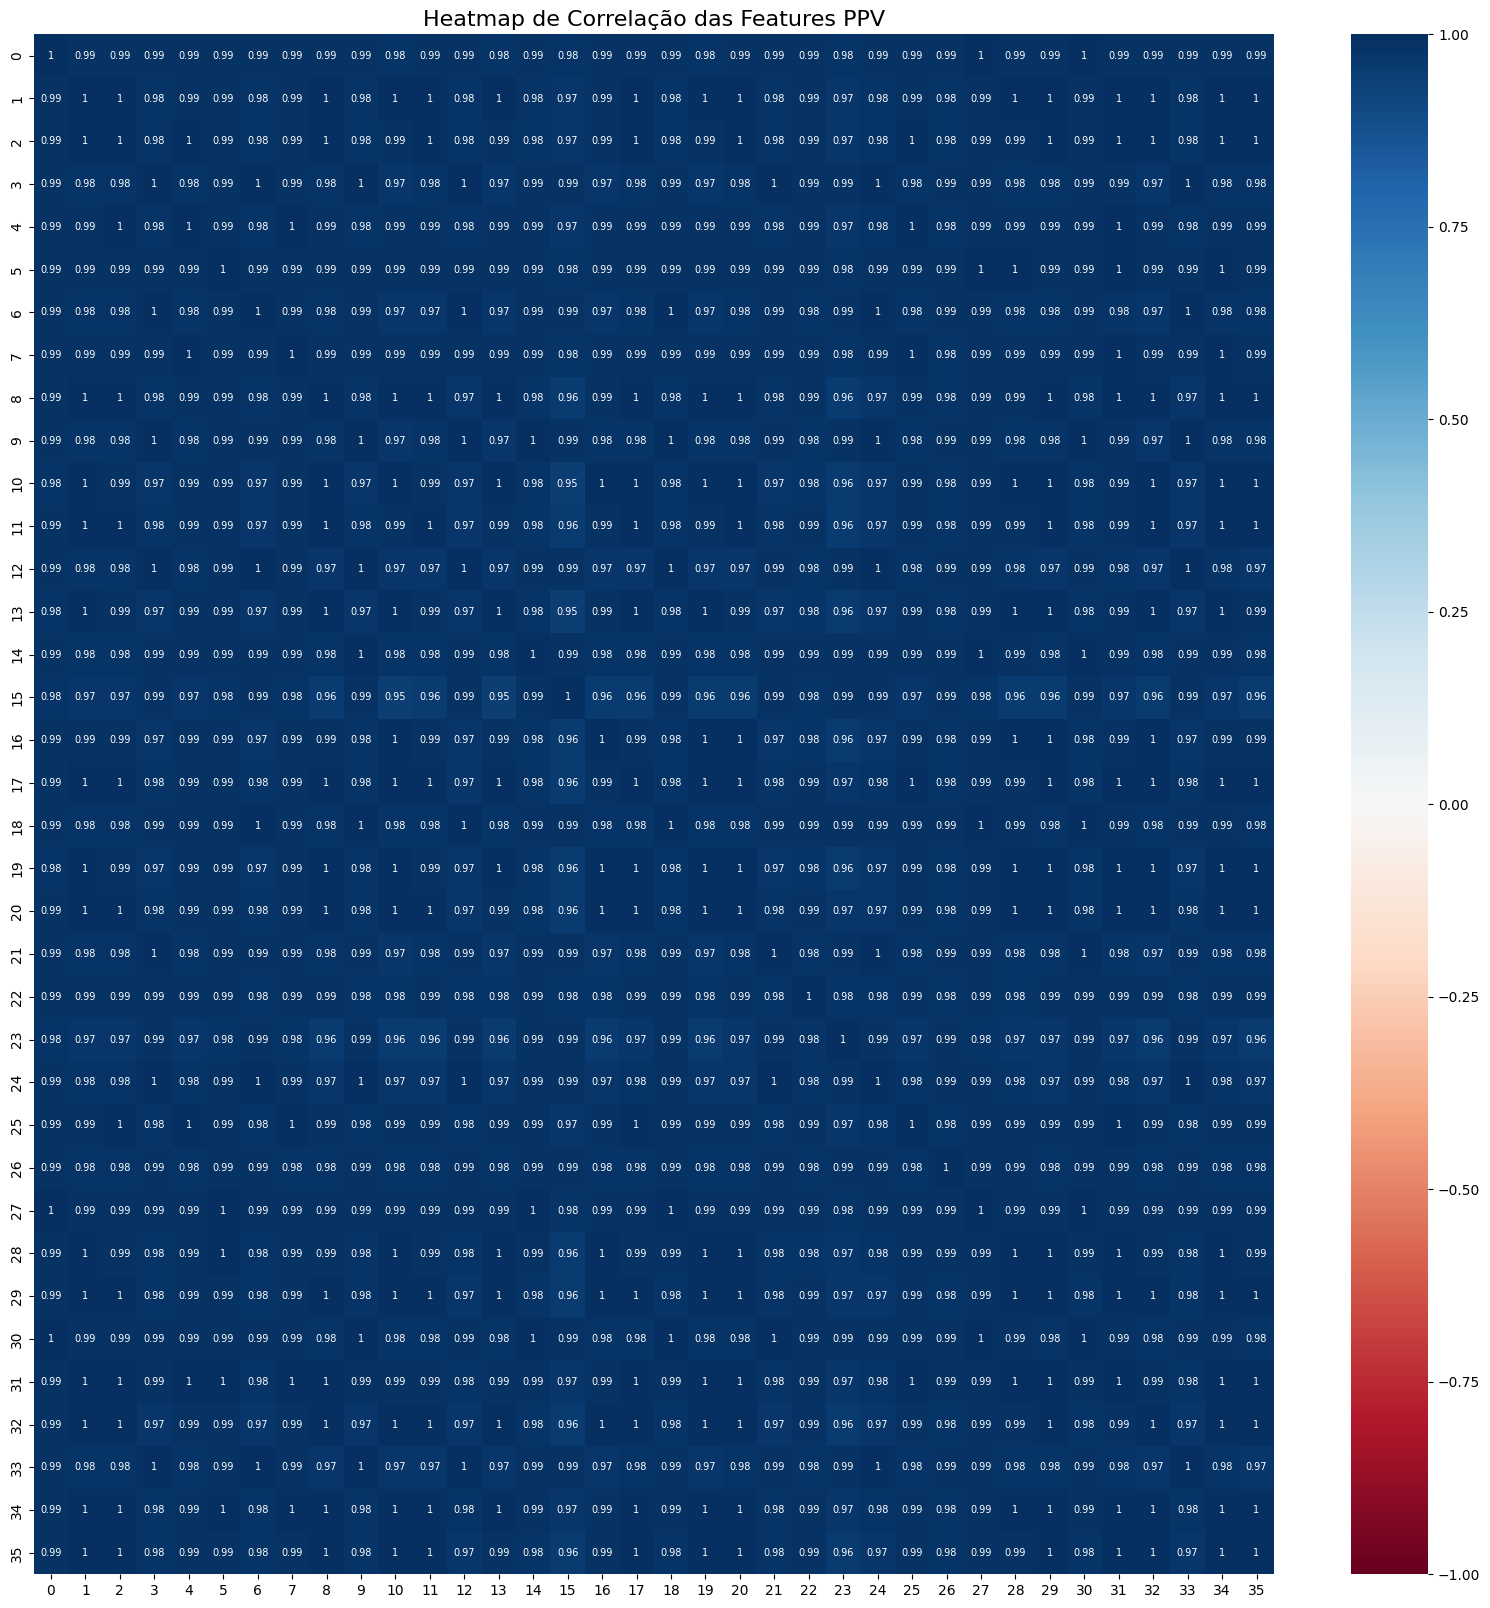

In [ ]:
ppv = pd.DataFrame(ppv_features.T) #ppv no dataframe
plt.figure(figsize=(20,20))
correlations1 = ppv.corr() #corelação entre todasas colunas do ppv (varia de -1 a 1)
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)

plt.title("Heatmap de Correlação das Features PPV", fontsize=16)
#(correlations1,2) arredonda o valor da corr p duas casas decimais

Text(0.5, 1.0, 'Heatmap de Correlação das Features PPV após Clustering')

<Figure size 1200x500 with 0 Axes>

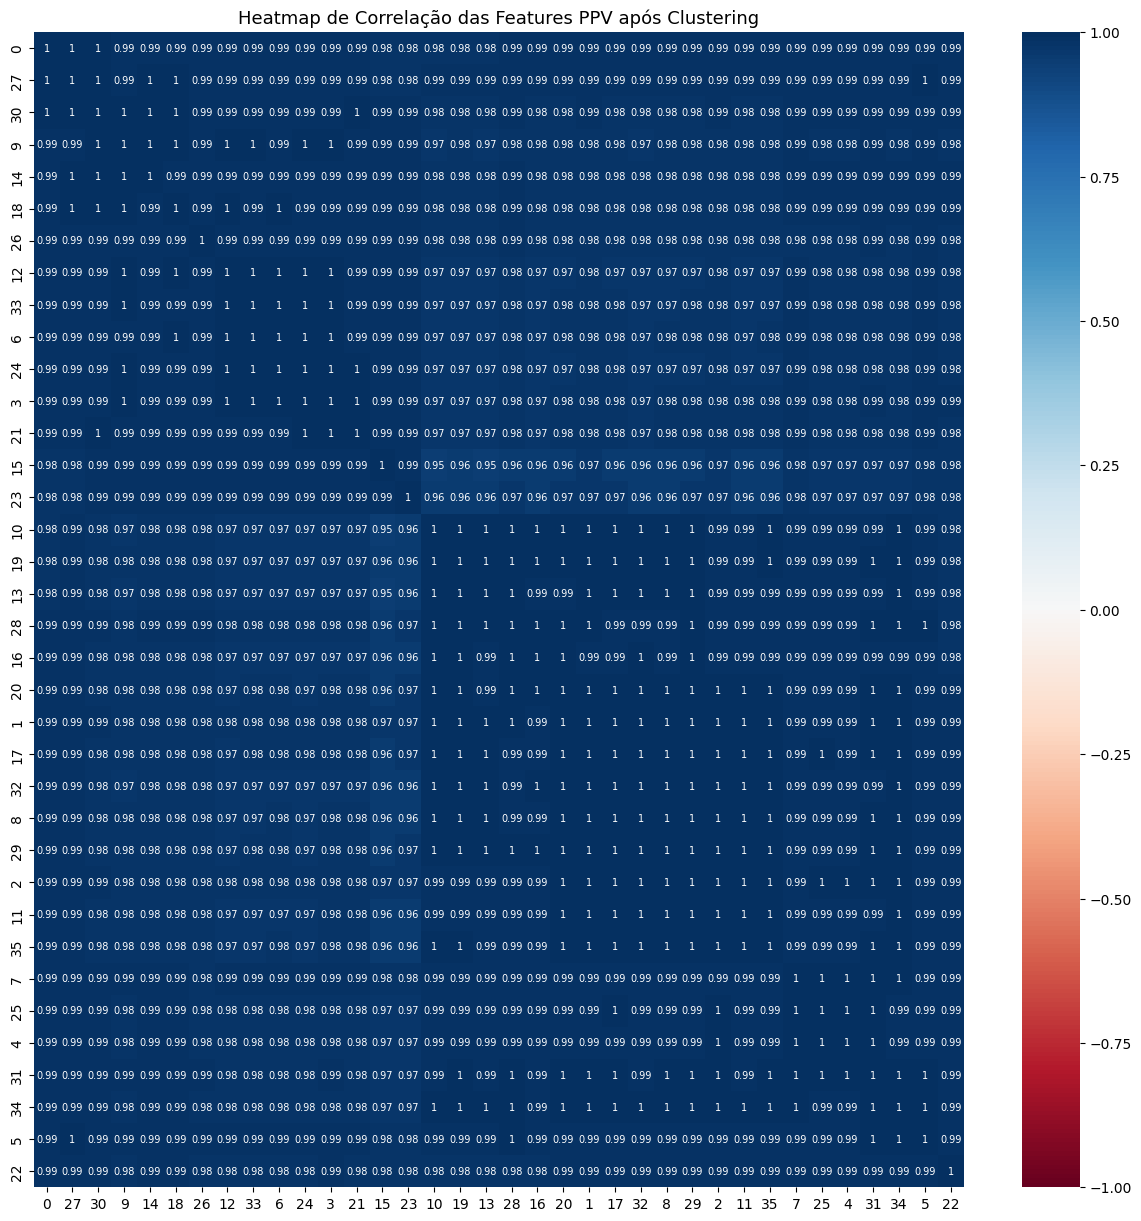

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity1 = 1 - abs(correlations1)
Z = linkage(squareform(dissimilarity1), 'complete') #agrupamento hierárquico usando complete linkage

# Clusterize the data
threshold = 0.000005 #dissimilaridade (distancia) entre dois clusters
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
#labels
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Construção de um novo DataFrame com as colunas ordenadas pelos clusters
for idx, i in enumerate(ppv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ppv[i])
    else:
        df_to_append = pd.DataFrame(ppv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,15))
correlations1 = clustered.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);
plt.title("Heatmap de Correlação das Features PPV após Clustering", fontsize=13)
#heatmap é desenhado para visualizar as correlações entre as features reorganizadas por clusters.

##LSPV Heatmap

Text(0.5, 1.0, 'Heatmap de Correlação das Features LSPV')

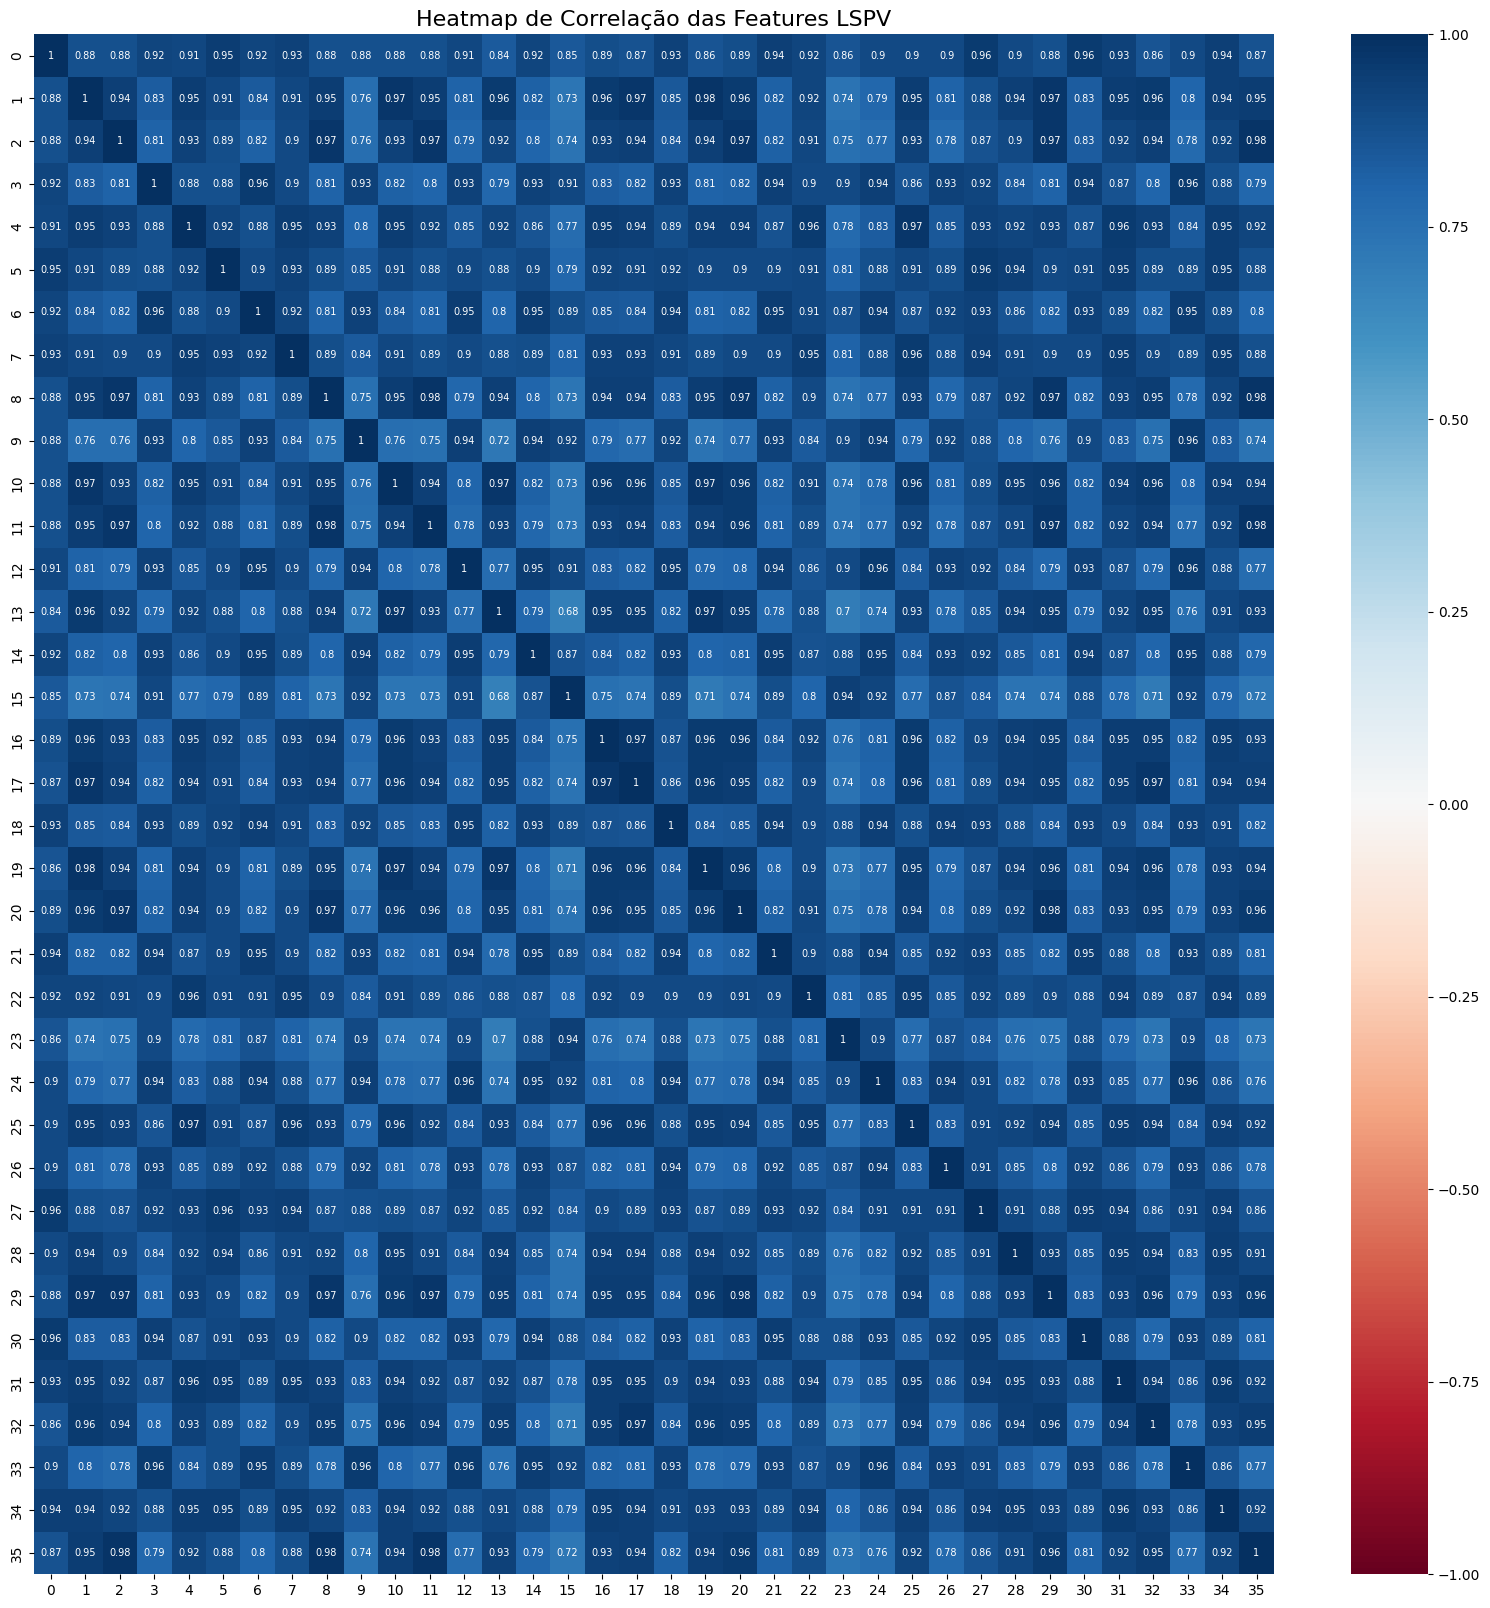

In [ ]:
lspv = pd.DataFrame(lspv_features.T)

plt.figure(figsize=(20,20))
correlations2 = lspv.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Heatmap de Correlação das Features LSPV", fontsize=16)

Text(0.5, 1.0, 'Heatmap de Correlação das Features LSPV após Clustering')

<Figure size 1200x500 with 0 Axes>

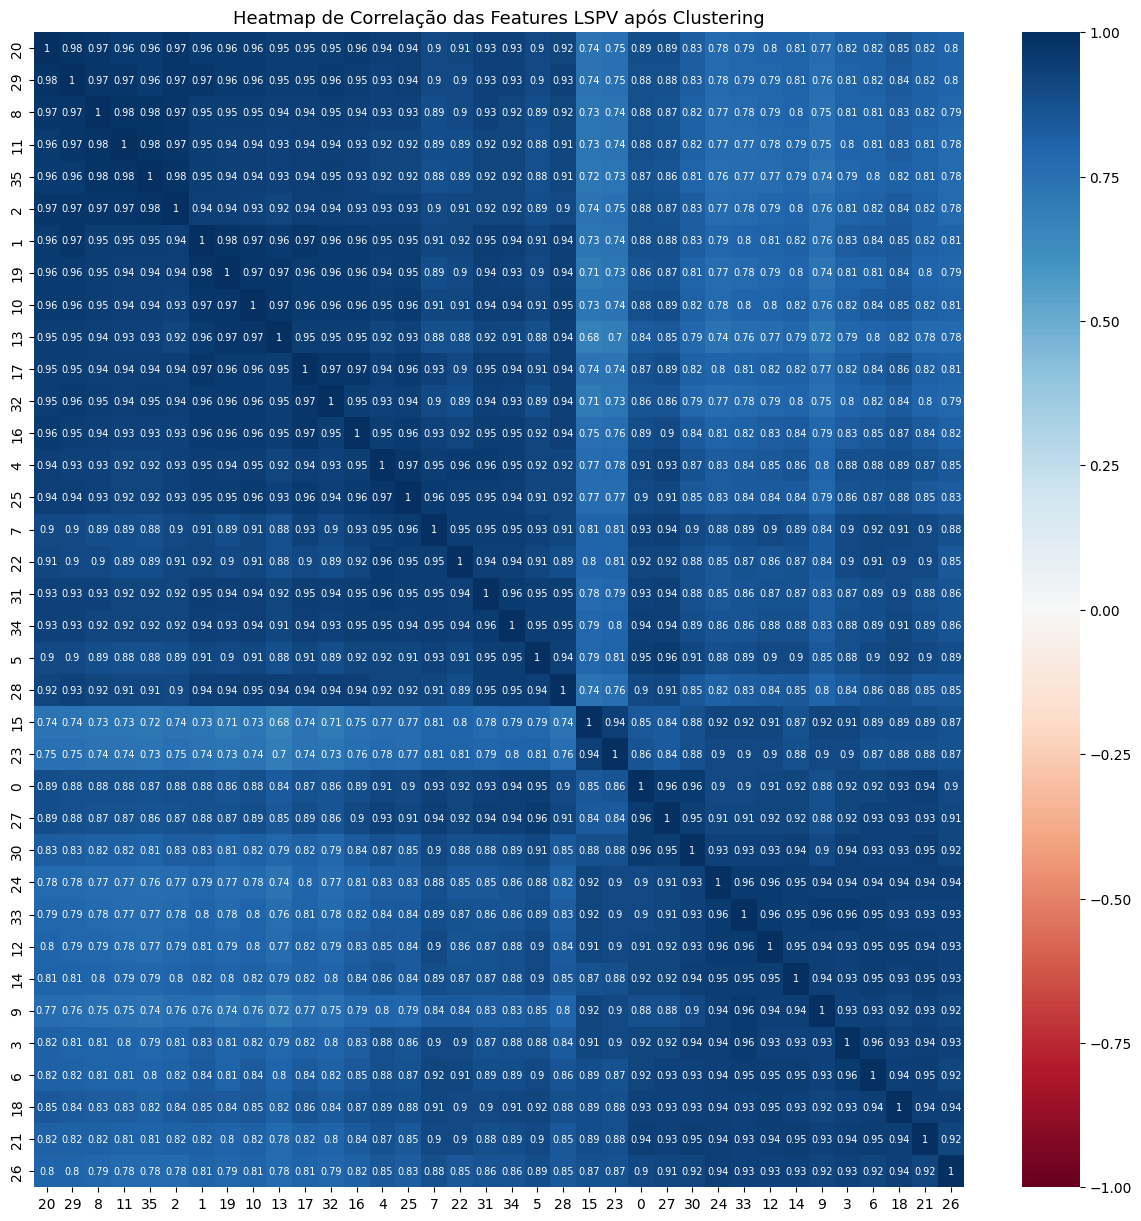

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity2 = 1 - abs(correlations2)
Z = linkage(squareform(dissimilarity2), 'complete')

# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)

for idx, i in enumerate(lspv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(lspv[i])
    else:
        df_to_append = pd.DataFrame(lspv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,15))
correlations2 = clustered.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Heatmap de Correlação das Features LSPV após Clustering", fontsize=13)

##MPV Heatmap

Text(0.5, 1.0, 'Heatmap de Correlação das Features MPV')

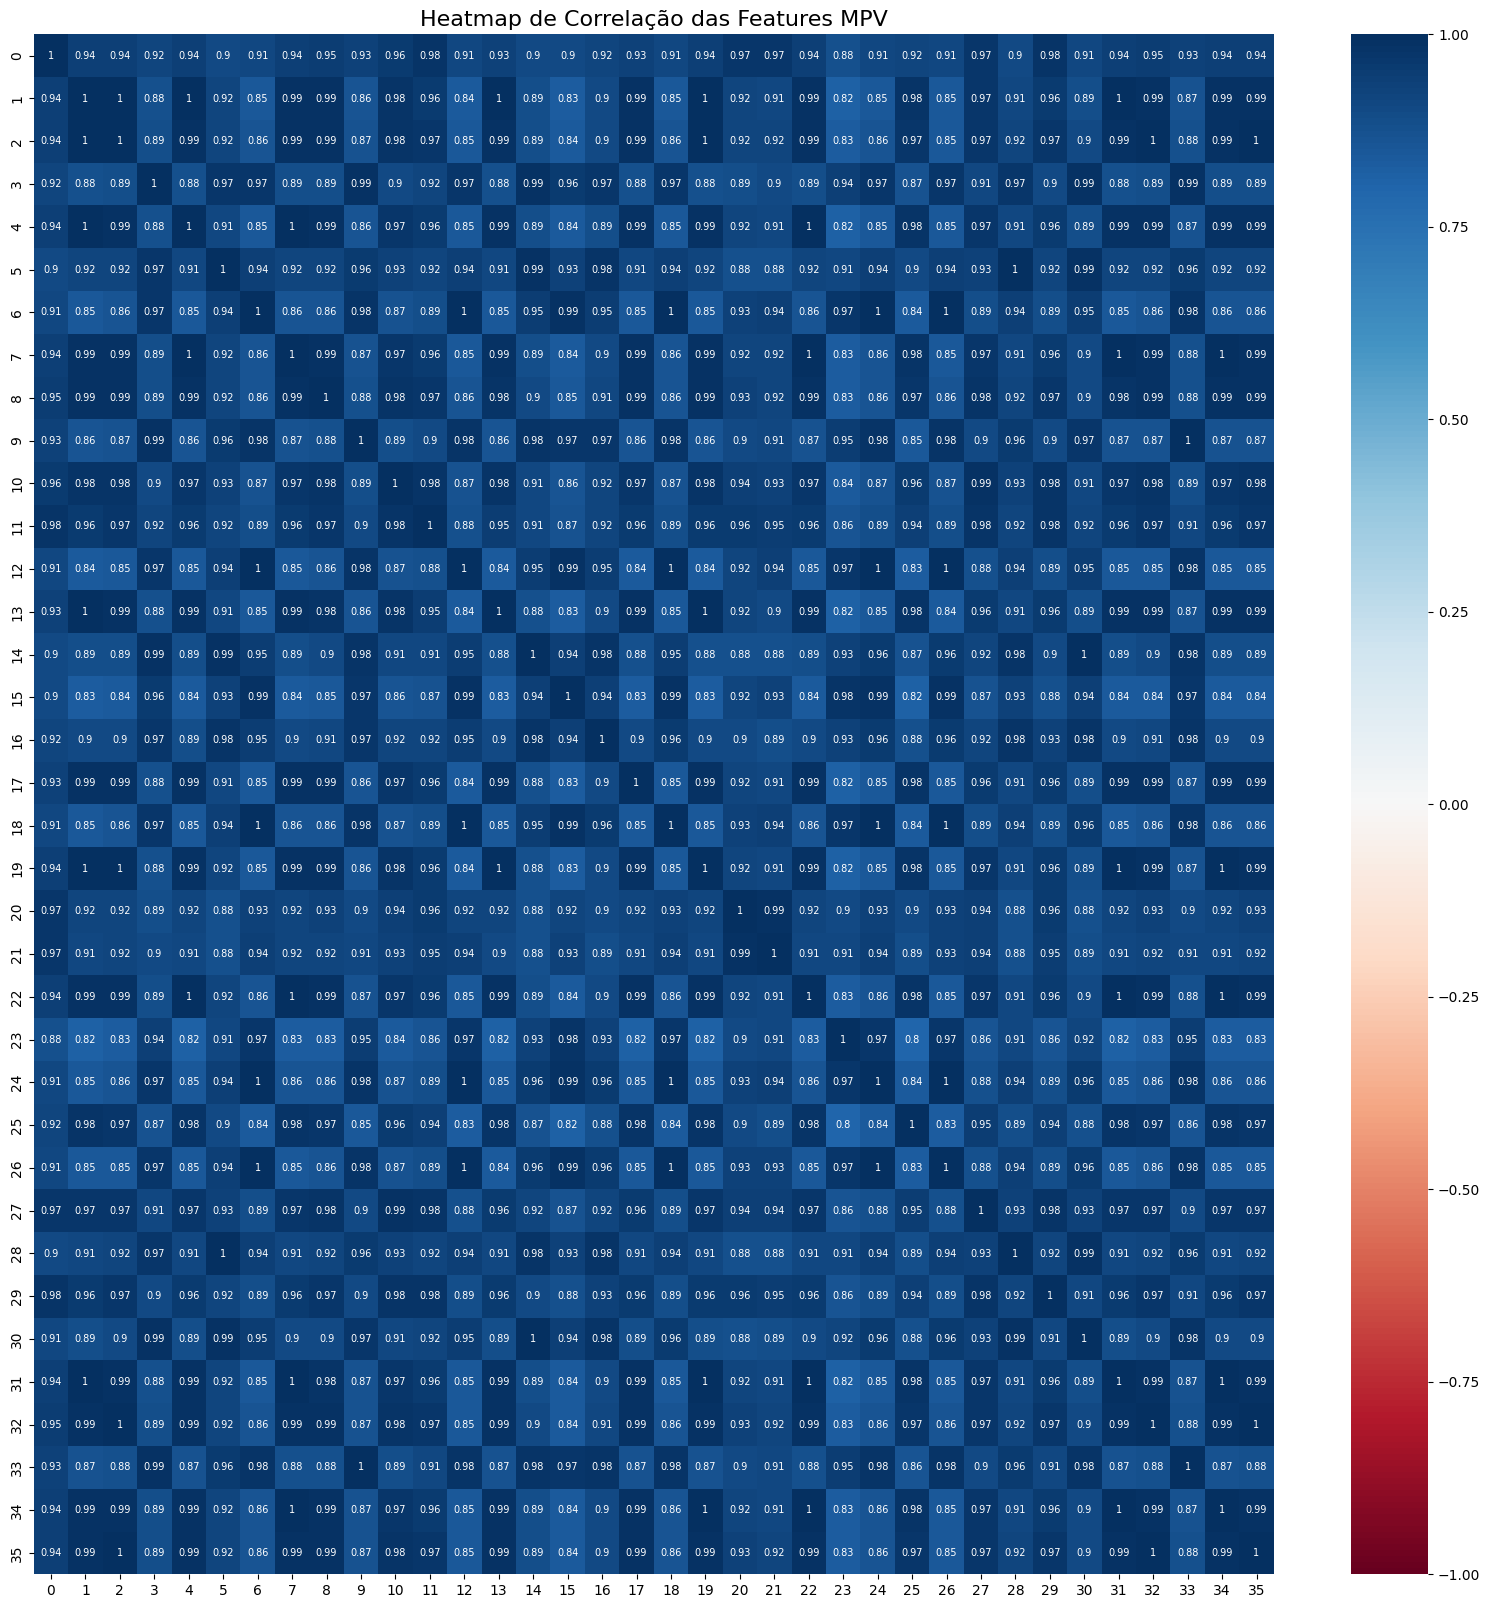

In [ ]:
mpv = pd.DataFrame(mpv_features.T)

plt.figure(figsize=(20,20))
correlations3 = mpv.corr()
sns.heatmap(round(correlations3,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);
plt.title("Heatmap de Correlação das Features MPV", fontsize=16)

Text(0.5, 1.0, 'Heatmap de Correlação das Features MPV após Clustering')

<Figure size 1200x500 with 0 Axes>

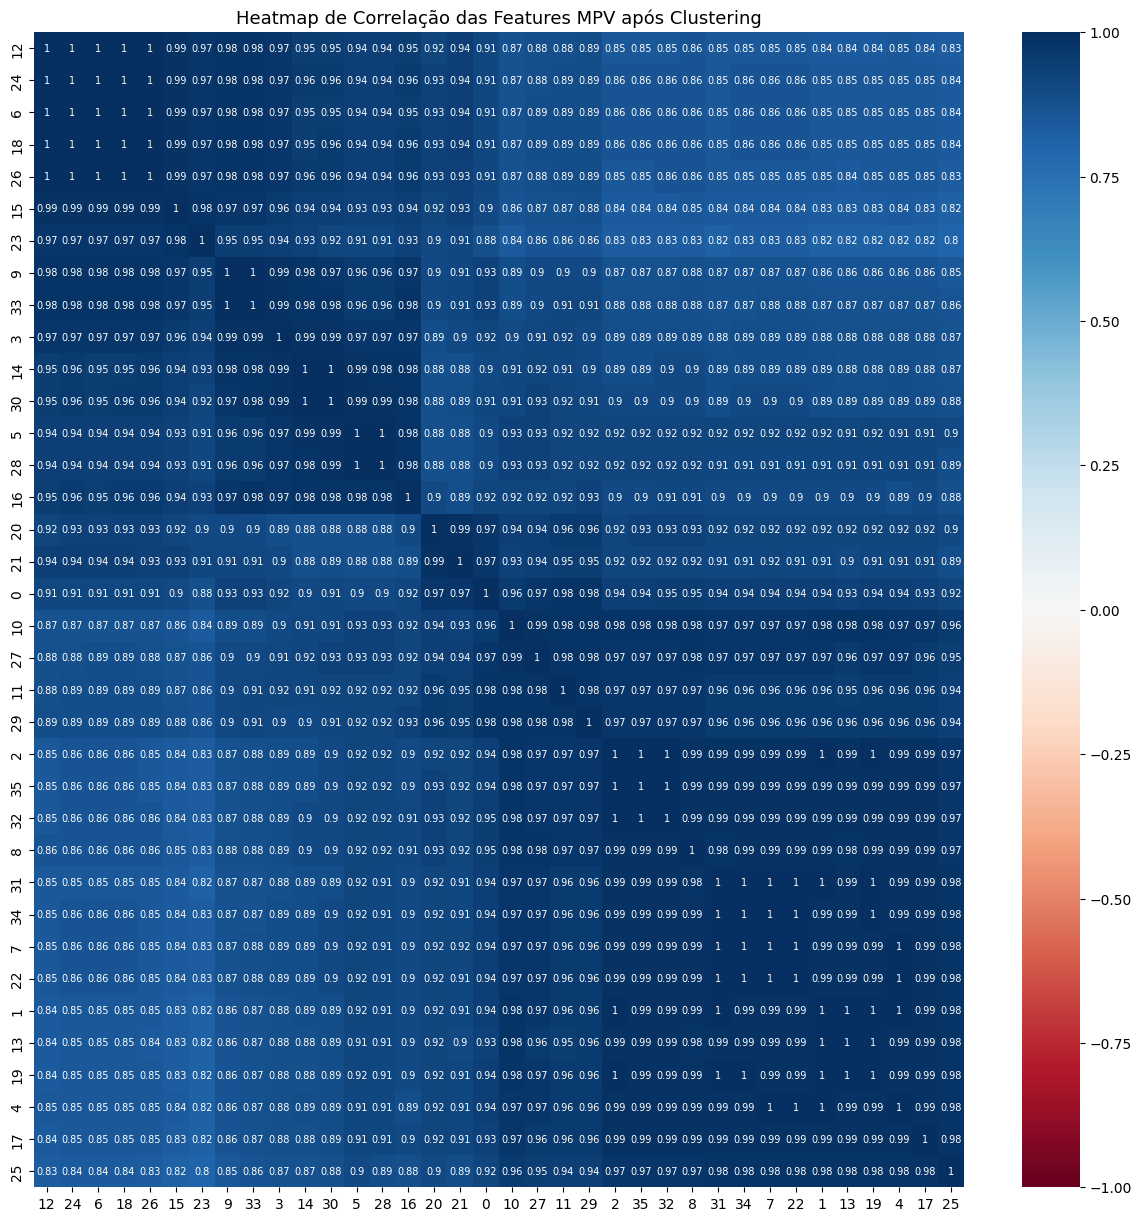

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity3 = 1 - abs(correlations3)
Z = linkage(squareform(dissimilarity3), 'complete')

# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)

for idx, i in enumerate(mpv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(mpv[i])
    else:
        df_to_append = pd.DataFrame(mpv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,15))
correlations3 = clustered.corr()
sns.heatmap(round(correlations3,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Heatmap de Correlação das Features MPV após Clustering", fontsize=13)

##MIPV Heatmap

Text(0.5, 1.0, 'Heatmap de Correlação das Features MIPV')

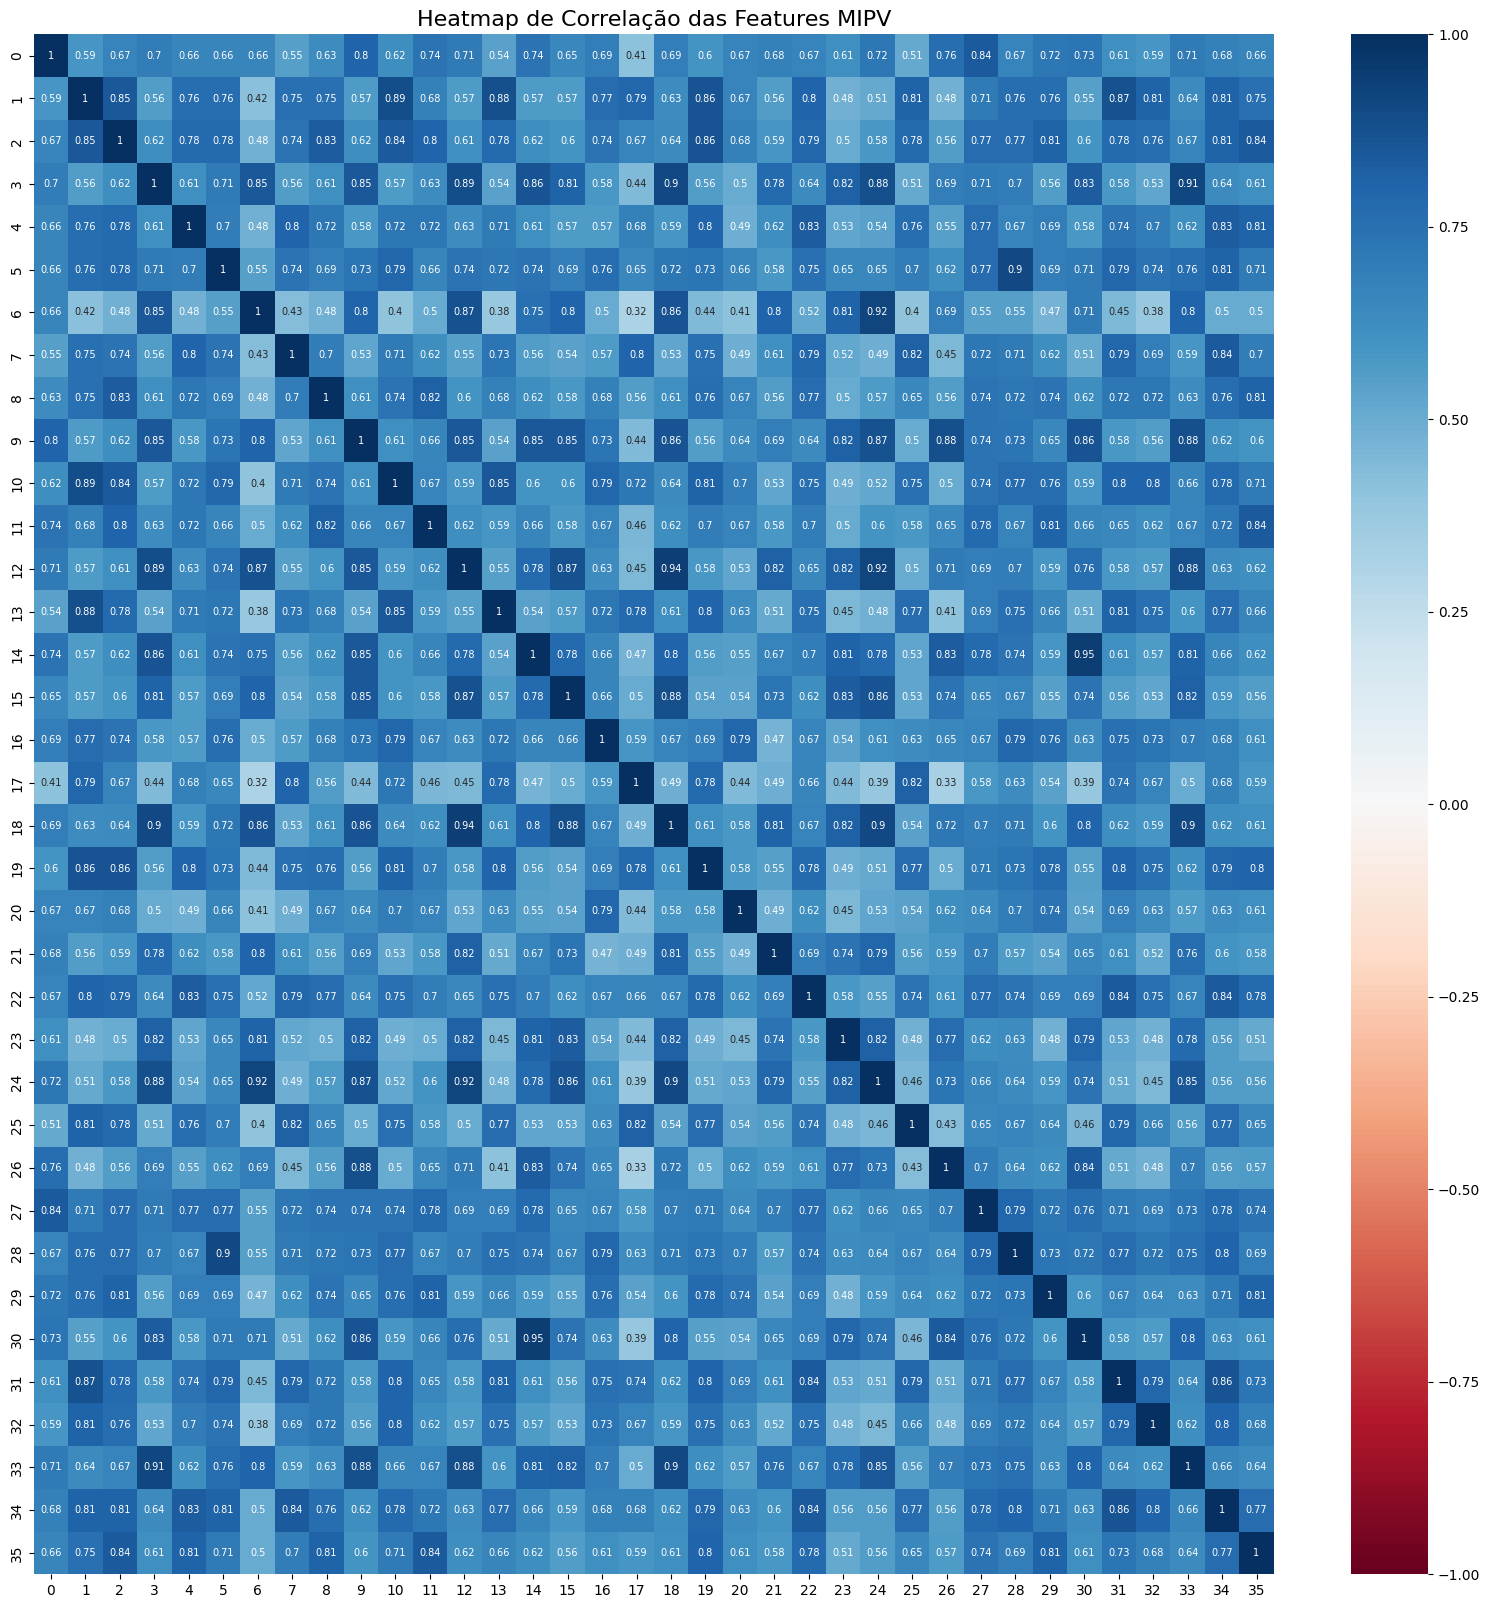

In [ ]:
mipv = pd.DataFrame(mipv_features.T)

plt.figure(figsize=(20,20))
correlations4 = mipv.corr()
sns.heatmap(round(correlations4,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Heatmap de Correlação das Features MIPV", fontsize=16)

Text(0.5, 1.0, 'Heatmap de Correlação das Features MIPV após Clustering')

<Figure size 1200x500 with 0 Axes>

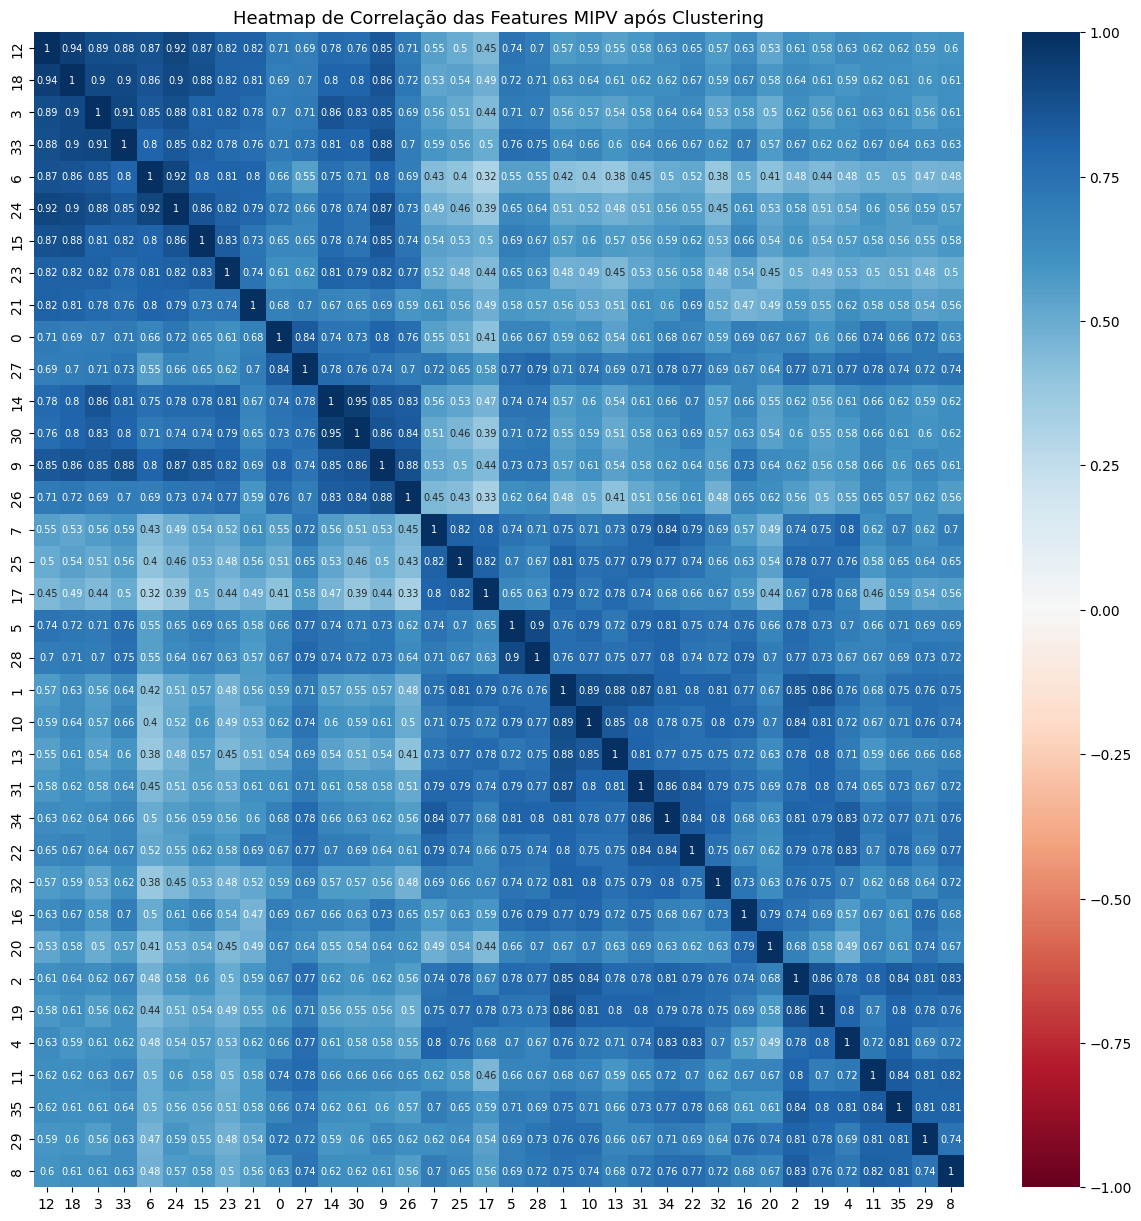

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity4 = 1 - abs(correlations4)
Z = linkage(squareform(dissimilarity4), 'complete')

# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)

for idx, i in enumerate(mipv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(mipv[i])
    else:
        df_to_append = pd.DataFrame(mipv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,15))
correlations4 = clustered.corr()
sns.heatmap(round(correlations4,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Heatmap de Correlação das Features MIPV após Clustering", fontsize=13)